In [1]:
DATASET_PATH = '/group/avfedor-g00/datasets/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'

In [2]:
import sys
print(sys.executable)

/opt/anaconda/bin/python


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
SCRATCH_PATH = '/scratch/jjvandu/'

In [5]:
!ls $SCRATCH_PATH

In [6]:
import wfdb
import pandas as pd
import os
import matplotlib.pyplot as plt
import ast
import numpy as np
from torch.utils.data import Dataset

In [7]:
# Define paths
DATASET_PATH = '/group/avfedor-g00/datasets/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
metadata_path = os.path.join(DATASET_PATH, 'ptbxl_database.csv')
agg_path = os.path.join(DATASET_PATH, 'scp_statements.csv')

In [8]:
scp_statements = pd.read_csv('./scp_statements.csv')

In [9]:
metadata = pd.read_csv(metadata_path)
metadata.head(10)

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
5,6,19005.0,18.0,1,NaN,58.0,2.0,0.0,CS-12 E,1984-11-28 13:32:13,...,True,", V1",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00006_lr,records500/00000/00006_hr
6,7,16193.0,54.0,0,NaN,83.0,2.0,0.0,CS-12 E,1984-11-28 13:32:22,...,True,NaN,NaN,NaN,NaN,NaN,NaN,7,records100/00000/00007_lr,records500/00000/00007_hr
7,8,11275.0,48.0,0,NaN,95.0,2.0,0.0,CS-12 E,1984-12-01 14:49:52,...,True,", II,AVF",", I-AVF,",NaN,NaN,NaN,NaN,9,records100/00000/00008_lr,records500/00000/00008_hr
8,9,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr
9,10,9456.0,22.0,1,NaN,56.0,2.0,0.0,CS-12 E,1984-12-12 14:12:46,...,True,NaN,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00010_lr,records500/00000/00010_hr


In [10]:
from tqdm import tqdm
from skimage import io, transform
from torchvision import transforms, utils

import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [11]:
# Define function to load raw data
def load_raw_data(df, sampling_rate, dataset_path):
    # Determine the filename column based on the sampling rate
    filenames = df.filename_lr if sampling_rate == 100 else df.filename_hr
    print (len(filenames))
    # Load the ECG signals
    data = [wfdb.rdsamp(os.path.join(dataset_path, filename))[0] for filename in tqdm(filenames)]
    return np.array(data)

In [12]:
# Load and convert annotation data
sampling_rate = 100
Y = pd.read_csv(metadata_path, index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [13]:
y_dic = Y.scp_codes.values[0]
print (y_dic)

{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}


In [14]:
# Load raw signal data
X = load_raw_data(Y, sampling_rate, DATASET_PATH)

21799


100%|██████████| 21799/21799 [01:38<00:00, 220.96it/s]


In [15]:
agg_df = pd.read_csv('./scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

In [16]:
agg_df.columns

Index(['description', 'diagnostic', 'form', 'rhythm', 'diagnostic_class',
       'diagnostic_subclass', 'Statement Category',
       'SCP-ECG Statement Description', 'AHA code', 'aECG REFID', 'CDISC Code',
       'DICOM Code'],
      dtype='object')

In [17]:
# Define function to aggregate diagnostic classes directly from metadata
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [18]:
# Apply diagnostic superclass (using the 'diagnostic_class' from metadata)
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [19]:
def consolidate_to_other(label_list):
    # Check if 'OTHER' is in the list
    if any(label != 'NORM' for label in label_list):
        return ['OTHER']
    return label_list

# Apply the mapping function
Y['diagnostic_superclass'] = Y['diagnostic_superclass'].apply(consolidate_to_other)

In [20]:
Y['diagnostic_superclass'].value_counts()

diagnostic_superclass
[OTHER]    12319
[NORM]      9069
[]           411
Name: count, dtype: int64

In [21]:
import torch
import torch.nn.functional as F

all_labels = ['NORM', 'OTHER']

label_to_index = {label: idx for idx, label in enumerate(all_labels)}

indices = [[label_to_index[label] for label in item] for item in Y['diagnostic_superclass']]

num_classes = len(all_labels)
one_hot_encoded = [F.one_hot(torch.tensor(idx_list, dtype=torch.long), num_classes=num_classes).sum(dim=0).float() for idx_list in indices]

In [22]:
Y['diagnostic_superclass'] = one_hot_encoded

In [23]:
Y_filtered = Y['diagnostic_superclass']

In [24]:
val_fold = 9
test_fold = 10

train_idx = ~(Y.strat_fold.isin([val_fold, test_fold]))
val_idx = (Y.strat_fold == val_fold)
test_idx = (Y.strat_fold == test_fold)

len(train_idx)

21799

In [25]:
X_train = X[train_idx]
Y_train = Y_filtered[train_idx]
X_val = X[val_idx]
Y_val = Y_filtered[val_idx]
X_test = X[test_idx]
Y_test = Y_filtered[test_idx]

In [26]:
from torch.utils.data import Dataset, DataLoader

class ECG_Dataset_Int(Dataset):

    def __init__(self, ecg_data, labels, transform=None):
        self.ecg_data = ecg_data
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.ecg_data)

    def __getitem__(self, idx):
        try:
            if torch.is_tensor(idx):
                idx = idx.tolist()
    
            ecg_signal = self.ecg_data[idx]
            label = self.labels.iloc[idx]
    
            if self.transform:
                sample = self.transform((ecg_signal, label))
                ecg_signal = sample['ecg']
                label = sample['label']
    
            return ecg_signal, label
        except IndexError as e:
            print(f"IndexError: {e} - Index out of bounds: {idx}")
            raise  # Re-raise the exception after logging

In [27]:
import torch
import torch.nn.functional as F

class ToTensorInt(object):
    def __call__(self, sample):
        ecg_signal, label = sample
        
        ecg_signal_tensor = torch.tensor(ecg_signal, dtype=torch.float32)
        label_tensor = label
        
        return {'ecg': ecg_signal_tensor, 'label': label_tensor}


In [29]:
from torch.utils.data.sampler import SubsetRandomSampler

def get_sampler(indices):
    return SubsetRandomSampler(indices)

test_indices1 = list(range(17084)) 
test_indices2 = list(range(2158))

batch_size = 4
trainset = ECG_Dataset_Int(ecg_data=X_train, labels=Y_train, transform=transforms.Compose([ToTensorInt()]))
trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, sampler=get_sampler(test_indices1), num_workers=2)

testset = ECG_Dataset_Int(ecg_data=X_test, labels=Y_test, transform=transforms.Compose([ToTensorInt()]))
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size, sampler=get_sampler(test_indices2), num_workers=2)

In [30]:
classes = ['NORM', 'OTHER']

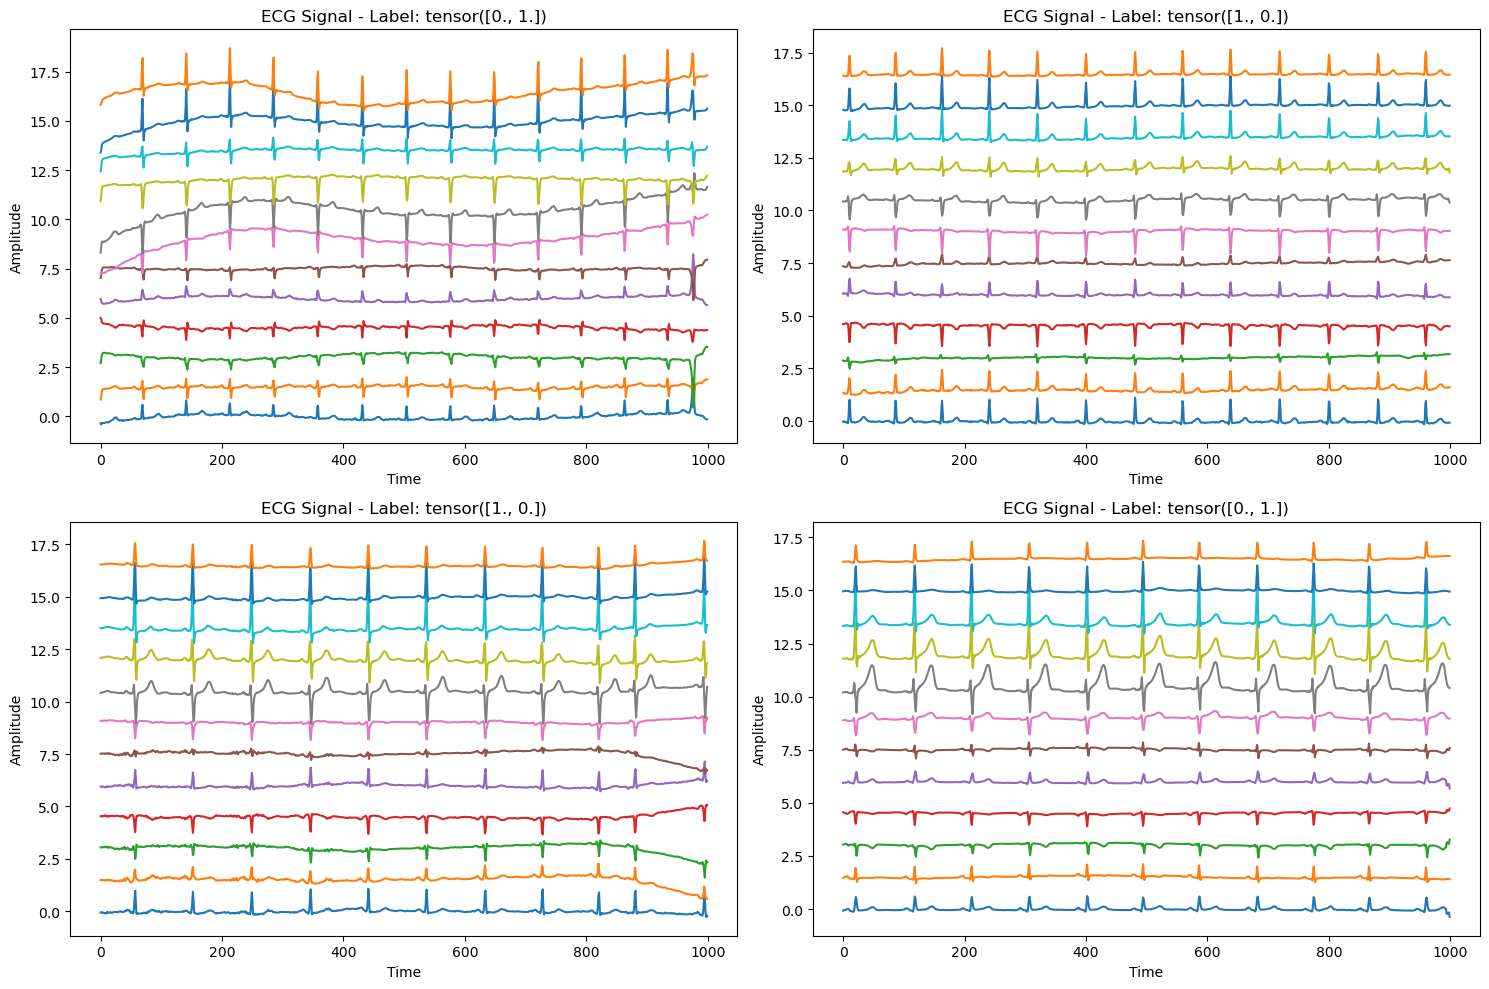

Sample 0: OTHER
Sample 1: NORM
Sample 2: NORM
Sample 3: OTHER


In [62]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ecg(signal, label, ax):
    for i in range(signal.shape[1]):  
        ax.plot(signal[:,i] + i * 1.5, label=f'Lead {i+1}') 
    ax.set_title(f'ECG Signal - Label: {label}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')

dataiter = iter(trainloader)
signals, labels = next(dataiter)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))  
for idx, ax in enumerate(axes.flat):
    plot_ecg(signals[idx], labels[idx], ax)

plt.tight_layout()  
plt.show()

class_names_mapping = {
    0: 'NORM',
    1: 'OTHER'
}

for j in range(4):
    class_names = [classes[k] for k in range(labels.shape[1]) if labels[j, k] == 1]
    print(f'Sample {j}: {" ".join(class_names)}')

In [63]:
signals = signals.transpose(1, 2)
signals = signals.to('cuda', non_blocking=True)
labels = labels.to('cuda', non_blocking=True)
        
print(signals.shape)
print(labels.shape)
outputs = model(signals)  
print(outputs.shape)
pred_labels = torch.sigmoid(outputs) > 0.5

torch.Size([4, 12, 1000])
torch.Size([4, 2])
torch.Size([4, 2])


In [64]:
len(pred_labels[0].tolist())

2

In [65]:
def get_class_names(encoded_labels, classes):
    return [classes[k] for k in range(len(encoded_labels)) if encoded_labels[k] == 1]

for j in range(labels.shape[0]):
    real_class_names = get_class_names(labels[j].tolist(), classes)
    pred_class_names = get_class_names(pred_labels[j].tolist(), classes)
    print(f'Sample {j}: Real: {" ".join(real_class_names)} | Predicted: {" ".join(pred_class_names)}')

Sample 0: Real: OTHER | Predicted: OTHER
Sample 1: Real: NORM | Predicted: NORM
Sample 2: Real: NORM | Predicted: OTHER
Sample 3: Real: OTHER | Predicted: OTHER


In [33]:
import torch.nn as nn
import torch.nn.functional as F

In [34]:
X.shape

(21799, 1000, 12)

In [39]:
batch_size = 128
num_input_channels = 12
num_timepoints = 1000
x = torch.randn(batch_size, num_input_channels, num_timepoints)
print (x.shape)

num_output_channels = 24
kernel_size = 3
stride = 1
padding = 1

torch.Size([128, 12, 1000])


In [40]:
from torch.utils.checkpoint import checkpoint

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv1d(num_input_channels, num_output_channels, kernel_size, stride, padding, padding_mode='zeros'), # first layer
            nn.BatchNorm1d(num_output_channels),
            nn.ReLU(),
            nn.Conv1d(num_output_channels, 2*num_output_channels, kernel_size, stride, padding, padding_mode='zeros'), # second layer
            nn.BatchNorm1d(2*num_output_channels),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(2*num_output_channels, 4*num_output_channels, kernel_size, stride, padding, padding_mode='zeros'),
            nn.BatchNorm1d(4*num_output_channels),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(24000, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [41]:
class MultiLabelSoftMarginLoss(nn.Module):
    def __init__(self, label_smoothing=0.0, reduction='mean'):
        super(MultiLabelSoftMarginLoss, self).__init__()
        assert 0 <= label_smoothing < 1, "label_smoothing value must be between 0 and 1."
        self.label_smoothing = label_smoothing
        self.reduction = reduction
        self.multi_label_soft_margin = nn.MultiLabelSoftMarginLoss(reduction=reduction)

    def forward(self, input, target):
        if self.label_smoothing > 0:
            # Calculate smoothed labels
            num_classes = target.size(1)  # Assumes target is [batch_size, num_classes]
            positive_smoothed_labels = 1.0 - self.label_smoothing
            negative_smoothed_labels = self.label_smoothing / (num_classes - 1)
            smoothed_target = target * positive_smoothed_labels + (1 - target) * negative_smoothed_labels
            target = smoothed_target

        loss = self.multi_label_soft_margin(input, target)
        return loss

In [42]:
model = MLP()
y = model(x)
print(y.shape)

import torch.optim as optim
model = model.cuda()
model = torch.compile(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

torch.cuda.empty_cache()

for epoch in range(5):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.transpose(1, 2)
        inputs = inputs.to('cuda', non_blocking=True)
        labels = labels.to('cuda', non_blocking=True)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i + 1) % 2000 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

torch.Size([128, 2])
[1,  2000] loss: 0.650
[1,  4000] loss: 0.552
[2,  2000] loss: 0.516
[2,  4000] loss: 0.506
[3,  2000] loss: 0.477
[3,  4000] loss: 0.468
[4,  2000] loss: 0.454
[4,  4000] loss: 0.451
[5,  2000] loss: 0.441
[5,  4000] loss: 0.426
Finished Training


In [66]:
correct = 0
total = 0
# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = inputs.transpose(1, 2)
        inputs = inputs.to('cuda', non_blocking=True)
        labels = labels.to('cuda', non_blocking=True)

        # Calculate outputs by running images through the network
        outputs = model(inputs)

        # Apply a threshold to determine the predicted labels
        predicted = torch.sigmoid(outputs) > 0.5   # Adjust threshold as needed

        # Calculate correct predictions
        correct += (predicted == labels).sum()
            
        total += labels.numel()  # Total number of labels

print(f"Total: {total}, Correct: {correct}")
print(f'Accuracy of the network: {100 * correct / total:.2f} %')


Total: 4316, Correct: 3279
Accuracy of the network: 75.97 %


In [67]:
# Assuming 'classes' is a list where the index corresponds to the label, e.g., classes = ['class0', 'class1', 'class2', 'class3', 'class4']
classes = ['NORM', 'OTHER']

# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# Again, no gradients needed
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = inputs.transpose(1, 2)  # Ensure the correct input shape for your model
        inputs = inputs.to('cuda', non_blocking=True)
        labels = labels.to('cuda', non_blocking=True)

        outputs = model(inputs)
        predicted = torch.sigmoid(outputs) > 0.5 # Convert outputs to binary predictions

        # Collect the correct predictions for each class
        for i in range(len(classes)):
            correct_pred[classes[i]] += ((predicted[:, i] == labels[:, i]) & (labels[:, i] == 1)).sum().item()
            total_pred[classes[i]] += (labels[:, i] == 1).sum().item()

# Print accuracy for each class
for classname, correct_count in correct_pred.items():
    if total_pred[classname] > 0:  # To avoid division by zero
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class {classname} is {accuracy:.1f} %')
    else:
        print(f'No samples for class {classname}')


Accuracy for class NORM is 65.3 %
Accuracy for class OTHER is 82.1 %


In [45]:
class ResidualBlock(nn.Module):
    def __init__(self, num_input_channels, num_output_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv1d(num_input_channels, num_output_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm1d(num_output_channels),
            nn.ReLU(),
            nn.Conv1d(num_output_channels, num_output_channels, kernel_size=3, stride=1, padding=1, bias=False), # second layer
            nn.BatchNorm1d(num_output_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or num_input_channels != num_output_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(num_input_channels, num_output_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(num_output_channels)
            )
    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = F.relu(out)

        return out

In [46]:
class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=2):
        super(ResNet, self).__init__()
        self.num_input_channels = 12
        self.conv1  = nn.Sequential(
            nn.Conv1d(12, 12, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(12),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResidualBlock, 12, 2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 24, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 48, 2, stride=2)        
        self.layer4 = self.make_layer(ResidualBlock, 96, 2, stride=2)  
        self.fc = nn.Linear(2976, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.num_input_channels, channels, stride))
            self.num_input_channels = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool1d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [47]:
def ResNet18():
    return ResNet(ResidualBlock)

In [48]:
net = ResNet18()

In [49]:
net = net.cuda()
net = torch.compile(net)

In [50]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
torch.cuda.empty_cache()

In [51]:
for epoch in range(5):
    print('\nEpoch: %d' % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, data in enumerate(trainloader, 0):
        #prepare dataset
        length = len(trainloader)
        inputs, labels = data
        inputs = inputs.transpose(1, 2)
        inputs = inputs.to('cuda', non_blocking=True)
        labels = labels.to('cuda', non_blocking=True)
        optimizer.zero_grad()
        
        #forward & backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print ac & loss in each batch
        sum_loss += loss.item()
        predicted = torch.sigmoid(outputs) > 0.5
        total += labels.numel()
        correct += (predicted == labels).sum()
        if i==0 or (i + 1) % 100 == 0:
            print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% ' % (epoch + 1, (i + 1 + epoch * length), sum_loss / (i + 1), 100. * correct / total))   # numel returns total number of elements in the tensor
        
    #get the ac with testdataset in each epoch
    print('Waiting Test...')
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            net.eval()
            inputs, labels = data
            inputs = inputs.transpose(1, 2)
            inputs = inputs.to('cuda', non_blocking=True)
            labels = labels.to('cuda', non_blocking=True)
            outputs = net(inputs)
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.numel()
            correct += (predicted == labels).sum()
        print('Test\'s ac is: %.3f%%' % (100 * correct / total))

print('Train has finished, total epoch is 5')


Epoch: 1
[epoch:1, iter:1] Loss: 0.697 | Acc: 50.000% 
[epoch:1, iter:100] Loss: 1.694 | Acc: 54.875% 
[epoch:1, iter:200] Loss: 1.249 | Acc: 54.375% 
[epoch:1, iter:300] Loss: 1.061 | Acc: 55.833% 
[epoch:1, iter:400] Loss: 0.964 | Acc: 56.250% 
[epoch:1, iter:500] Loss: 0.901 | Acc: 57.375% 
[epoch:1, iter:600] Loss: 0.859 | Acc: 57.812% 
[epoch:1, iter:700] Loss: 0.827 | Acc: 58.179% 
[epoch:1, iter:800] Loss: 0.802 | Acc: 58.906% 
[epoch:1, iter:900] Loss: 0.782 | Acc: 59.639% 
[epoch:1, iter:1000] Loss: 0.764 | Acc: 60.163% 
[epoch:1, iter:1100] Loss: 0.750 | Acc: 60.409% 
[epoch:1, iter:1200] Loss: 0.739 | Acc: 60.875% 
[epoch:1, iter:1300] Loss: 0.727 | Acc: 61.308% 
[epoch:1, iter:1400] Loss: 0.714 | Acc: 62.071% 
[epoch:1, iter:1500] Loss: 0.705 | Acc: 62.458% 
[epoch:1, iter:1600] Loss: 0.697 | Acc: 62.742% 
[epoch:1, iter:1700] Loss: 0.687 | Acc: 63.213% 
[epoch:1, iter:1800] Loss: 0.676 | Acc: 63.965% 
[epoch:1, iter:1900] Loss: 0.669 | Acc: 64.500% 
[epoch:1, iter:2000] L

In [52]:
class BasicBlock1D(nn.Module):
    expansion = 1

    def __init__(self, num_input_channels, num_output_channels, stride=1, downsample=None):
        super(BasicBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(num_input_channels, num_output_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(num_output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(num_output_channels, num_output_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(num_output_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [53]:
class ResNet1D(nn.Module):
    def __init__(self, num_input_channels, block, layers, num_classes):
        super(ResNet1D, self).__init__()
        self.num_output_channels = 12
        self.num_input_channels = num_input_channels
        self.conv1 = nn.Conv1d(self.num_input_channels, self.num_output_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(self.num_output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)
        self.layer1 = self._make_layer(block, 12, layers[0])
        self.layer2 = self._make_layer(block, 24, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 48, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 96, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(96 * block.expansion, num_classes)

    def _make_layer(self, block, num_output_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.num_output_channels != num_output_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.num_output_channels, num_output_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(num_output_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.num_output_channels, num_output_channels, stride, downsample))
        self.num_output_channels = num_output_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.num_output_channels, num_output_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

In [54]:
def resnet18_1d(num_input_channels=12, block=BasicBlock1D, layers=[2, 2, 2, 2], num_classes=2):
    """Constructs a ResNet-18-1D model."""
    # model = ResNet1D(BasicBlock1D, [2, 2, 2, 2], num_features, projection_size)
    model = ResNet1D(num_input_channels, block=block, layers=layers, num_classes=num_classes)
    return model

In [55]:
net2 = resnet18_1d()

In [56]:
net2 = net2.cuda()
net2 = torch.compile(net2)

In [57]:
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = optim.SGD(net2.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [59]:
for epoch in range(5):
    print('\nEpoch: %d' % (epoch + 1))
    net2.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, data in enumerate(trainloader, 0):
        #prepare dataset
        length = len(trainloader)
        inputs, labels = data
        inputs = inputs.transpose(1, 2)
        inputs = inputs.to('cuda', non_blocking=True)
        labels = labels.to('cuda', non_blocking=True)
        optimizer.zero_grad()
        
        #forward & backward
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print ac & loss in each batch
        sum_loss += loss.item()
        predicted = torch.sigmoid(outputs).round()
        total += labels.numel()
        correct += (predicted == labels).sum()
        if i==0 or (i + 1) % 100 == 0:
            print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% ' % (epoch + 1, (i + 1 + epoch * length), sum_loss / (i + 1), 100. * correct / total))   # numel returns total number of elements in the tensor
        
    #get the ac with testdataset in each epoch
    print('Waiting Test...')
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            net2.eval()
            inputs, labels = data
            inputs = inputs.transpose(1, 2)
            inputs = inputs.to('cuda', non_blocking=True)
            labels = labels.to('cuda', non_blocking=True)
            outputs = net(inputs)
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.numel()
            correct += (predicted == labels).sum()
        print('Test\'s ac is: %.3f%%' % (100 * correct / total))

print('Train has finished, total epoch is 5')


Epoch: 1
[epoch:1, iter:1] Loss: 0.145 | Acc: 100.000% 
[epoch:1, iter:100] Loss: 0.472 | Acc: 76.250% 
[epoch:1, iter:200] Loss: 0.464 | Acc: 76.625% 
[epoch:1, iter:300] Loss: 0.454 | Acc: 78.167% 
[epoch:1, iter:400] Loss: 0.442 | Acc: 79.469% 
[epoch:1, iter:500] Loss: 0.438 | Acc: 79.575% 
[epoch:1, iter:600] Loss: 0.445 | Acc: 79.354% 
[epoch:1, iter:700] Loss: 0.450 | Acc: 79.161% 


KeyboardInterrupt: 